# Language Identification

The goal is to identify the language in which a document, message, or sentence is written. To achieve this goal, I propose the following methodology. First, to transform a text into character n-gram features. Second, to build a machine-learned classifier to predict the language in which a text is written, using those character n-gram features. Last, to evaluate the performance of the approach proposed here on a variety of datasets and against some of the most popular language identification libraries in the Python ecosystem.

Last, it is worth making clear that the language identification system will be limited to 14 out of 24 official languages of the European Union, namely:

1. Czech
2. Danish
3. Dutch
4. English
5. Finnish
6. French
7. German
8. Hungarian
9. Italian
10. Polish
11. Portuguese
12. Romanian
13. Spanish
14. Swedish

The above languages were chosen due to data availability matters, but mostly because their alphabet is based on modern Latin.

## 0. Requirements

To encourage reproducibility, the technologies—and their version—used to approach this task are listed below:

1. Python **3.7.4**
2. NumPy **1.17.2**
3. SciPy **1.3.1**
4. pandas **0.25.1**
5. scikit-learn **0.21.3**
6. Matplotlib **3.1.1**
7. langid **1.1.6**
8. langdetect **1.0.8**
9. fasttext **0.9.2**

In [1]:
import itertools
import os
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import display
from IPython.core.display import HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold

from utils import LanguageIdentificationHelper

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
CURRENT_PATH = os.path.abspath(os.getcwd())
DATA_PATH = os.path.join(CURRENT_PATH, 'data')

To build the language identification system, a large collection of sentences provided by [Tatoeba](https://tatoeba.org/eng) is going to be used. (On the download date, July 29, 2020, this collection consists of 8,544,796 sentences.)

In [4]:
DATASETS = {
    'original': 'sentences.csv',
    'filtered': 'filtered_sentences.csv',
    'normalized': 'normalized_sentences.csv',
    'sampled': 'sampled_sentences.csv',
    'model_selection': 'model_selection.csv',
    'tatoeba_test': 'tatoeba_test.csv',
    'wili_test': 'wili_test.csv',
    'liga_test': 'liga_test.csv',
    'experiments': 'experiments.csv'
}

DATASETS = {key: os.path.join(DATA_PATH, fname) for key, fname in DATASETS.items()}

In [5]:
RANDOM_SEED = 91

## 1. Data Preprocessing

Throughout this section, let's filter sentences written in one out of the 14 languages described above. Each sentence is associated with an [ISO 639-3](https://en.wikipedia.org/wiki/List_of_ISO_639-3_codes) language code.

Furthermore, each sentence is preprocessed, normalized, or cleaned as follows. First, non-alphabetic characters are removed from a text. Second, alphabetic characters are converted to lowercase. Last, consecutive repetitions of the white-space character are reduced to only one occurrence.

In [6]:
LANGUAGES = {
    'ces': 'Czech',
    'dan': 'Danish',
    'nld': 'Dutch',
    'eng': 'English',
    'fin': 'Finnish',
    'fra': 'French',
    'deu': 'German',
    'hun': 'Hungarian',
    'ita': 'Italian',
    'pol': 'Polish',
    'por': 'Portuguese',
    'ron': 'Romanian',
    'spa': 'Spanish',
    'swe': 'Swedish'
}

MIN_LANG_FREQ = 10000

In [7]:
ALPHABET = ("abcdefghijklmnopqrstuvwxyz"
            + "äöüß" # German
            + "àâæçéèêëïîôœùûüÿ" # French
            + "áéíóúüñ" # Spanish
            + "àèéìòóù" # Italian
            + "éëïóöü" # Dutch
            + "ãáàâçéêíõóôúü" # Portuguese
            + "áéíöóőüúű" # Hungarian
            + "äåö" # Finnish
            + "äåéö" # Swedish
            + "áčďéěíňóřšťúůýž" # Czech
            + "ąćęłńóśźż" # Polish
            + "ăâîșşțţ" # Romanian
            + "åæéø") # Danish

ALPHABET = re.sub('\s+', '', ALPHABET.lower()).strip()
ALPHABET = list(set(list(ALPHABET)))
ALPHABET.sort()
ALPHABET = ''.join(ALPHABET) + ' '

As previously stated, let's filter sentences by the language in which they are written, additionally discarding those duplicate.

In [8]:
if not os.path.isfile(DATASETS['filtered']):
    df = pd.read_csv(DATASETS['original'],
                     sep='\t',
                     header=None,
                     names=['id', 'lang', 'text'])

    mask = df['lang'].isin(list(LANGUAGES.keys()))
    df = df.loc[mask]
    
    df = df.drop_duplicates(subset='text')\
         .sort_values(by='id')

    lang_freq = df.groupby(['lang'])['lang']\
                .agg(['count'])\
                .reset_index()
    lang_freq = lang_freq.loc[lang_freq['count'] >= MIN_LANG_FREQ]
    
    df = df.loc[df['lang'].isin(lang_freq['lang'].values)]
    
    df.to_csv(DATASETS['filtered'], index=False)

In [9]:
def preprocess_text(text):
    """Text preprocessing.
    
    This function removes any non-alphabetic character. A non-alphabetic character
    is one that does not belong to any of the alphabets that this system is capable
    of identifying.
    
    Parameters
    ----------
    text: str
    
    Returns
    -------
    str
    """
    text = text.lower()
    
    text = re.sub(rf'[^{ALPHABET}]', '', text)
    
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    
    return text

Preprocessing, normalizing, or cleaning those language-filtered sentences takes a relatively long time, i.e. in the order of minutes.

In [10]:
if not os.path.isfile(DATASETS['normalized']):
    df = pd.read_csv(DATASETS['filtered'])
    
    sentences = []    
    for index, row in df.iterrows():
        text = row['text']
        f0 = len(text)
        
        text = preprocess_text(text)
        f1 = len(text)
        
        if f1 == 0:
            continue
            
        sentences.append({
            'id': row['id'],
            'lang': row['lang'],
            'f0': f0,
            'f1': f1,
            'text': text
        })
    
    sentences = pd.DataFrame(sentences)
    
    columns = ['id', 'lang', 'f0', 'f1', 'text']
    sentences = sentences[columns]
    
    sentences.to_csv(DATASETS['normalized'], index=False)

## 2. Data Exploration and Sampling

In [11]:
df = pd.read_csv(DATASETS['normalized'])

### 2.1 Language Distribution

In [12]:
lang_dist = df.groupby(['lang'])['lang']\
            .agg(['count'])\
            .reset_index()

lang_dist = lang_dist\
            .sort_values(by='count', ascending=False)\
            .replace(to_replace={'lang': LANGUAGES})\
            .reset_index()\
            .drop(columns='index')

In [13]:
display(HTML(lang_dist.to_html()))

,lang,count
0,English,1341444
1,Italian,761481
2,German,516360
3,French,430973
4,Portuguese,365818
5,Spanish,319704
6,Hungarian,286181
7,Dutch,115952
8,Finnish,114111
9,Polish,107147


### 2.2 Sentences

In [14]:
def draw_cdf(
        X,
        ax, xlabel, title,
        nbins=10, range_=None,
        color='blue'):
    """Plot a cumulative distribution function."""
    ax.hist(X, bins=nbins, density=True, histtype='step',
            cumulative=True, range=range_, linewidth=2.0,
            color=color)
    
    percentiles = np.arange(.25, 1, .25)
    for pctl in percentiles:
        pctl_value = np.percentile(X, int(pctl*100))
    
        ax.axhline(y=pctl, linestyle='dashdot', linewidth=1.0, color='black')
    
        ax.annotate('{:.0f}% ({:.0f})'.format((pctl*100), np.ceil(pctl_value)),
                    xy=(np.ceil(pctl_value), pctl-.05), color='black')
    
    ax.grid(True)
    ax.locator_params(tight=True, nbins=nbins)
    ax.set_xlabel(xlabel)
    
    ax.set_title(title)

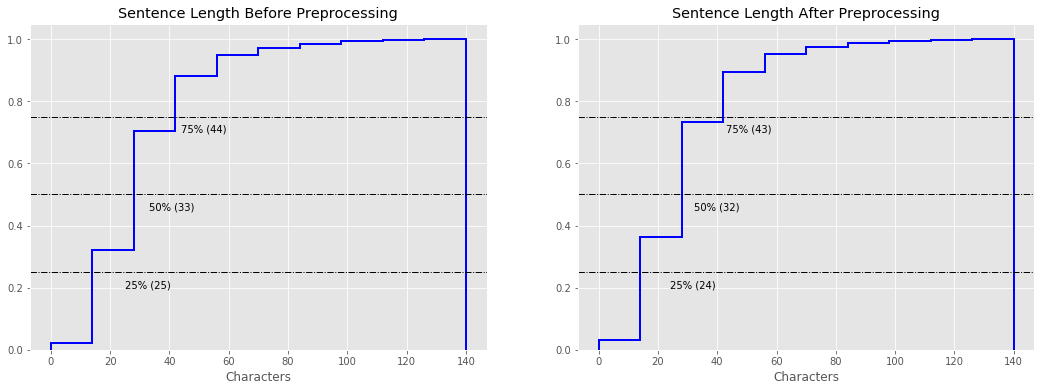

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

draw_cdf(df['f0'].sort_values(),
         ax[0], 'Characters', 'Sentence Length Before Preprocessing',
         range_=(0, 140))

draw_cdf(df['f1'].sort_values(),
         ax[1], 'Characters', 'Sentence Length After Preprocessing',
         range_=(0, 140))

plt.show()

As depicted in the above figure, the text normalization removes only one non-alphabetic character. With this in mind, we can infer that sentences are mainly simple and that that non-alphabetic character corresponds to the full stop or period character.

### 2.3 Dataset and Language Sampling

Let's split the whole dataset into training, development, and test sets. In terms of proportions, 60% of the dataset is going to be used to learn prediction models, whereas 20% of it to rank potential prediction models. Last, 20% of the dataset will be used to perform the model evaluation.

In [16]:
DATASET_SPLIT = {
    'train': .6,
    'dev': .2,
    'test': .2
}

In [17]:
def dataset_sampling(df):
    """Dataset sampling.
    
    The whole dataset is split and sampled in a stratified way,
    i.e., according to language distribution.
    
    Parameters
    ----------
    df: pd.DataFrame
    
    Returns
    -------
    pd.DataFrame
    """
    # Shuffle the dataset
    df = df.sample(n=None, frac=1., replace=False,
                   random_state=RANDOM_SEED)
    
    ids = []
    sentences = None
    
    columns = df.columns.tolist()
    
    for dataset, lang in itertools.product(DATASET_SPLIT.keys(), df['lang'].unique()):
        dataset_size = df.shape[0] * DATASET_SPLIT[dataset]
        
        mask = (df['lang'] == lang)
        lang_distribution = df.loc[mask].shape[0] / df.shape[0]
        sample_size = int(np.round(lang_distribution * dataset_size, 0))
        
        partial_df = df.loc[mask & (~df['id'].isin(ids))]
        
        sample_size = (
            sample_size if sample_size <= partial_df.shape[0]
            else partial_df.shape[0]
        )
        
        sample = partial_df.sample(n=sample_size,
                                   replace=False,
                                   random_state=RANDOM_SEED)
        
        ids += sample['id'].values.tolist()
        
        sample['dataset'] = dataset
        
        sentences = (
            sample.copy(deep=True) if sentences is None
            else sentences.append(sample.copy(deep=True), ignore_index=True)
        )
    
    columns = ['dataset'] + columns
    sentences = sentences[columns]
    
    return sentences

In [18]:
if not os.path.isfile(DATASETS['sampled']):
    df = dataset_sampling(df.copy(deep=True))
    
    df.to_csv(DATASETS['sampled'], index=False)

Next, let's develop a function, i.e. `language_sampling`, to draw samples according to a variety of criteria. These samples are useful to find the best sampling strategy for training purposes.

In [19]:
def merge_sentences(df, min_length):
    """Merge sentences into one.
    
    Sentences are merged into one so that its length is greater than or equal to
    ``min_length`` characters.
    
    Parameters
    ----------
    df: pd.DataFrame    
    min_length: int
        The minimum length, in terms of characters, that a sentence must be.
    
    Returns
    -------
    pd.DataFrame
    """
    # Shuffle and sort the dataset
    df = df[['lang', 'f1', 'text']]\
         .sample(n=None, frac=1., replace=False,
                 random_state=RANDOM_SEED)\
         .sort_values(by='lang')
    
    dataset_size = df.shape[0]
    df = df.append({'lang': 'unk', 'f1': 0, 'text': ''},
                   ignore_index=True)
    
    length = 0
    sentences = []
    lang = None
    
    count = 0
    
    dataset = []
    
    for i, (index, row) in enumerate(df.iterrows()):
        if (length >= min_length
                or (isinstance(lang, str) and lang != row['lang'])
                or i == dataset_size):
            sentence = ' '.join(sentences)
            sentence = re.sub(r'\s+', ' ', sentence)
            sentence = sentence.strip()
            
            dataset.append({
                'id': count,
                'lang': lang,
                'f1': len(sentence),
                'text': sentence
            })
            
            length = 0
            sentences = []
            
            count += 1
        
        sentences.append(row['text'])
        lang = row['lang']
        length += row['f1']
    
    return pd.DataFrame(dataset)

In [20]:
def language_sampling(
        df,
        method,
        n=None,
        frac=None,
        min_length=0,
        discard_sentences=True
        ):
    """Language sampling.
    
    This function allows for developing several sampling strategies to train or
    evaluate the language identification system.
    
    Parameters
    ----------
    df: pd.DataFrame    
    method: str, ['uniform', 'stratified']    
    n: int, optional
        If ``method='uniform'``, the number of sentences to draw from the
        dataset for each language. Cannot be used with `frac`.    
    frac: float, optional
        If ``method='stratified'``, the fraction of the dataset to draw a
        sample. Cannot be used with `n`.    
    min_length: int
        The minimum length, in terms of characters, that a sentence must be.        
    discard_sentences: bool
        If ``discard_sentences=True``, those sentences whose length is less
        than ``min_length`` characters are discarded.
    
    Returns
    -------
    pd.DataFrame
    """
    if (not isinstance(method, str)
            or method not in ('uniform', 'stratified')):
        raise ValueError("Set either 'uniform' or 'stratified' to `method`.")
    
    if (method == 'uniform'
            and not isinstance(n, int)):
        raise ValueError("`n` has to be an integer value.")
    elif (method == 'stratified'
            and not isinstance(frac, float)):
        raise ValueError("`frac` has to be a float value.")
    
    if discard_sentences and min_length > 1:
        df = df.loc[df['f1'] >= min_length]
    
    # Shuffle the dataset
    df = df[['id', 'lang', 'f1', 'text']]\
         .sample(n=None, frac=1., replace=False,
                 random_state=RANDOM_SEED)
    
    if (isinstance(frac, float)
            and frac == 1.):
        return df[['lang', 'f1', 'text']]
    
    ids = []
    sentences = None
    
    for lang in df['lang'].unique():
        sample_size = n
        
        if method == 'stratified':
            lang_distribution = df.loc[df['lang'] == lang].shape[0] / df.shape[0]
            sample_size = lang_distribution * (df.shape[0] * frac)
            sample_size = int(np.round(sample_size, 0))
        
        mask = ((df['lang'] == lang) & (~df['id'].isin(ids)))
        partial_df = df.loc[mask]
        
        sample_size = (
            sample_size if sample_size <= partial_df.shape[0]
            else partial_df.shape[0]
        )
        
        sample = partial_df.sample(n=sample_size,
                                   replace=False,
                                   random_state=RANDOM_SEED)
        
        ids += sample['id'].values.tolist()
        
        sentences = (
            sample.copy(deep=True) if sentences is None
            else sentences.append(sample.copy(deep=True), ignore_index=True)
        )
    
    return sentences[['lang', 'f1', 'text']]

In [21]:
def perform_language_sampling(
        df,
        sampling_strategies,
        output_path
        ):
    """Perform language sampling.
    
    Parameters
    ----------
    df: pd.DataFrame    
    sampling_strategies: list    
    output_path: str
    """
    mask = ((df['f1'] > 0) & (df['text'].notnull()))
    df = df.loc[mask]
    
    for strtg in sampling_strategies:
        if (not strtg['discard_sentences']
                and strtg['min_length'] == 0):
            continue
        
        dataset_path = os.path.join(output_path, strtg['dataset'])
        if not os.path.isdir(dataset_path):
            os.makedirs(dataset_path)
            
        fname = ('method={}'.format(strtg['method'])
                 + '_n={}'.format(strtg['n'])
                 + '_frac={}'.format(strtg['frac'])
                 + '_min_length={}'.format(strtg['min_length'])
                 + '_discard_sentences={}'.format(strtg['discard_sentences'])
                 + '.csv')
        fname = os.path.join(dataset_path, fname)
        
        if os.path.isfile(fname):
            continue
        
        mask = df['dataset'] == strtg['dataset']
        if re.search('_', strtg['dataset']):
            mask = df['dataset'].isin(strtg['dataset'].split('_'))
        
        dataset = df.loc[mask]
        
        if not strtg['discard_sentences']:
            sentences_fname = ('merged_sentences'
                               + '_min_length={}'.format(strtg['min_length'])
                               + '.csv')
            sentences_fname = os.path.join(dataset_path, sentences_fname)
            
            if not os.path.isfile(sentences_fname):
                dataset = merge_sentences(dataset.copy(deep=True),
                                          strtg['min_length'])
                
                dataset.to_csv(sentences_fname, index=False)
            else:
                dataset = pd.read_csv(sentences_fname)
        
        sample = language_sampling(
            dataset.copy(deep=True),
            method=strtg['method'],
            n=strtg['n'],
            frac=strtg['frac'],
            min_length=strtg['min_length'],
            discard_sentences=strtg['discard_sentences']
        )

        sample.to_csv(fname, index=False)

Sampling according to the following criteria takes a long time, i.e., in the order of minutes.

In [22]:
min_length = [0, 5, 10, 20, 40, 100, 140]

uniform_sampling = {
    'dataset': ['train'],
    'method': ['uniform'],
    'n': [1000, 4000, 8000, 10000, 12000],
    'frac': [None],
    'min_length': min_length,
    'discard_sentences': [True, False]
}

uniform_sampling = ParameterGrid(uniform_sampling)
uniform_sampling = list(uniform_sampling)

uniform_sampling += [{
    'dataset': 'dev',
    'method': 'uniform',
    'n': 1000,
    'frac': None,
    'min_length': 0,
    'discard_sentences': True
}]

stratified_sampling = {
    'dataset': ['train'],
    'method': ['stratified'],
    'n': [None],
    'frac': [.1, .2, .4, .8, 1.],
    'min_length': min_length,
    'discard_sentences': [True, False]
    }

stratified_sampling = ParameterGrid(stratified_sampling)
stratified_sampling = list(stratified_sampling)

sampling_strategies = uniform_sampling + stratified_sampling

In [23]:
TATOEBA_PATH = os.path.join(DATA_PATH, 'tatoeba')

df = pd.read_csv(DATASETS['sampled'])

perform_language_sampling(df.copy(deep=True),
                          sampling_strategies,
                          TATOEBA_PATH)

df = None

## 3. Language Identification System

The system architecture can be viewed as a pipeline consisting of a text preprocessing module, a vectorizer that transforms text into character n-gram features, and a machine-learned classifier that predicts the language in which a document, message, or sentence is written. The following figure illustrates this architecture.

![System Architecture](img/architecture.svg "System Architecture")
<div align="center" style="margin-top: 10px;"><b>Figure</b>: System Architecture</div>

### 3.1 Feature Extraction

A preprocessed, normalized, or cleaned document, message, or sentence is transformed into character n-gram features through a vectorizer. Particularly, the vectorizer applies the *tf-idf* weighting scheme to learn feature vectors.

In [24]:
def vectorize_documents(
        documents,
        analyzer,
        ngram_range,
        max_df,
        min_df,
        binary):
    """Build a vectorizer from a collection of documents."""
    vectorizer = TfidfVectorizer(
        input='content',
        lowercase=True,
        analyzer=analyzer,
        stop_words=None,
        ngram_range=ngram_range,
        max_df=max_df,
        min_df=min_df,
        binary=binary
    )
    
    X = vectorizer.fit_transform(documents)
    
    return X, vectorizer

### 3.2 Machine-learned Classification

After learning character n-gram features, a machine-learned classifier receives a feature vector and assigns a class label to a given text. This class label corresponds to the language the classifier predicts a document, message, or sentence is written in. As the language identification system is learned on 14-language data, its predictions are approached as a multi-class classification task.

In [25]:
def build_classifier(
        train,
        analyzer,
        ngram_range,
        max_df,
        min_df,
        binary
        ):
    """Vectorize a collection of documents and train a machine-learned classifier."""
    ngram_features, vectorizer = vectorize_documents(
        train['text'].values.tolist(),
        analyzer,
        ngram_range,
        max_df,
        min_df,
        binary
    )
    
    y = train['lang'].values.tolist()
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    param_grid = {
        'C': np.power(10., np.arange(-2, 3, dtype=float)),
        'penalty': ['l2'], 'solver': ['liblinear'],
        'multi_class': ['ovr']
    }
    
    clf = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=param_grid,
                       scoring='accuracy',
                       n_jobs=5,
                       iid=False,
                       cv=cv,
                       refit=True)
    
    clf.fit(ngram_features, y)
    
    cv_score = clf.best_score_
    
    return cv_score, vectorizer, clf.best_estimator_

In [26]:
def model_evaluation(y_true, y_pred):
    """Perform the model evaluation."""
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
       
    return accuracy, f1

In [27]:
LANG_TO_IDX = {lang: i for i, lang in enumerate(LANGUAGES.keys())}
IDX_TO_LANG = {i: lang for lang, i in LANG_TO_IDX.items()}

RESULT_HEADER = [
    'train',
    'method',
    'n',
    'frac',
    'min_length',
    'discard_sentences',
    'cv_score',
    'evaluation',
    'accuracy',
    'f1_score',
    'analyzer',
    'ngram_range',
    'max_df',
    'min_df',
    'binary',
    'vectorizer_id',
    'vectorizer_size',
    'classifier_id',
    'classifier_size'
]

Learning models takes a long time, i.e., in the order of hours. However, the reader may limit experiments that are run to a small number, depending on his or her discretion.

In [28]:
def learn_classifiers(
        train_path,
        result_fname,
        test_fname=None,
        save_models=False,
        persistence_path=None,
        params_frac=.05
        ):
    """Learn classifiers."""
    fnames = [
        fname for fname in os.listdir(train_path)
        if (re.match('method=[a-z]{7,10}', fname) and fname.endswith('.csv'))
    ]
    
    param_grid = {
        'analyzer': ['char', 'char_wb'],
        'ngram_range': [(i, i) for i in range(2, 5)],
        'max_df': np.linspace(.75, .95, 5),
        'min_df': np.arange(3, 30, 9),
        'binary': [True, False]
    }
    
    param_grid = ParameterGrid(param_grid)
    grid_size = len(param_grid)
    
    np.random.seed(RANDOM_SEED)
    
    sample_size = int(np.round(grid_size * params_frac, 0))
    indexes = np.random.choice(grid_size, size=sample_size, replace=False)
    
    results = []
    
    if (save_models
            and not isinstance(persistence_path, str)):
        raise ValueError("Set a value to `persistence_path`.")
    elif save_models:
        persistence_path = {
            'vectorizer': os.path.join(persistence_path, 'vectorizers'),
            'classifier': os.path.join(persistence_path, 'classifiers')
        }   
    
    for id_, (fname, index) in enumerate(itertools.product(fnames, indexes)):
        result = {p: None for p in RESULT_HEADER}
        
        for p, val in re.findall('([a-z_]+)=([^_]+)', fname.rstrip('.csv')):
            result[p.lstrip('_')] = (None if val == 'None' else val)
        
        if (result['method'] == 'stratified'
                and float(result['frac']) >= 0.4):
            continue
        
        fname = os.path.join(train_path, fname)
        result['train'] = fname.split(os.sep)[-2]
        
        train = pd.read_csv(fname)
        train = train[['lang', 'text']]
        train = train.replace(to_replace={'lang': LANG_TO_IDX})
        
        params = param_grid[index]
        
        result['analyzer'] = params['analyzer']
        result['ngram_range'] = ','.join([str(num) for num in params['ngram_range']])
        result['max_df'] = '{:.2f}'.format(params['max_df'])
        result['min_df'] = str(params['min_df'])
        result['binary'] = str(params['binary'])
        
        cv_score, vectorizer, clf = build_classifier(
            train,
            params['analyzer'],
            params['ngram_range'],
            params['max_df'],
            params['min_df'],
            params['binary']
        )
        
        result['cv_score'] = '{:.4f}'.format(cv_score)
        
        if isinstance(test_fname, str):
            result['evaluation'] = test_fname.split(os.sep)[-2]
            
            test = pd.read_csv(test_fname)
            test = test[['lang', 'text']]
            test = test.replace(to_replace={'lang': LANG_TO_IDX})
            
            ngram_features = vectorizer.transform(test['text'].values.tolist())
            y_pred = clf.predict(ngram_features)
            
            accuracy, f1 = model_evaluation(test['lang'].values.tolist(),
                                            y_pred)
            
            result['accuracy'] = '{:.4f}'.format(accuracy)
            result['f1_score'] = '{:.4f}'.format(f1)
        
        if save_models:
            for str_obj, path in persistence_path.items():
                if not os.path.isdir(path):
                    os.makedirs(path)
                
                obj = clf if str_obj == 'classifier' else vectorizer
                obj_fname = os.path.join(persistence_path[str_obj],
                                         '{}.joblib'.format(id_))
            
                if not os.path.isfile(obj_fname):
                    joblib.dump(obj, obj_fname)
            
                result['{}_id'.format(str_obj)] = str(id_)
                
                obj_size = os.path.getsize(obj_fname) / 1000
                result['{}_size'.format(str_obj)] = '{:.2f}'.format(obj_size)
        
        results.append(result)
        
        pd.DataFrame(results)[RESULT_HEADER]\
        .to_csv(result_fname, index=False, mode='w')

On the other hand, these experiments aim to find out how much data are required to build a system capable of identifying—with high accuracy—the language in which a document, message, or sentence is written. For this reason, machine-learned classifiers are trained on a variety of collections, drawn according to different sampling criteria, namely: sampling method, sample size, minimum sentence length, and whether to discard sentences whose length is less than a threshold or merge them into one until its length is greater than or equal to the threshold.

In [29]:
MODEL_PERSISTENCE_PATH = os.path.join(TATOEBA_PATH, 'models')

if not os.path.isfile(DATASETS['model_selection']):
    train_path = os.path.join(TATOEBA_PATH, 'train')
    
    test_fname = 'method=uniform_n=1000_frac=None_min_length=0_discard_sentences=True.csv'
    test_fname = os.path.join(TATOEBA_PATH, 'dev', test_fname)
    
    learn_classifiers(
        train_path,
        DATASETS['model_selection'],
        test_fname=test_fname,
        save_models=True,
        persistence_path=MODEL_PERSISTENCE_PATH
    )

In total, 290 classifiers were trained. Note that this took around 14 hours.

In [30]:
df = pd.read_csv(DATASETS['model_selection'])

df['size'] = df['vectorizer_size'] + df['classifier_size']

In [31]:
print('The minimum size of a language identification model is {:.2f} kb.'.format(df['size'].min())
      + '\n'
      + 'The maximum size is {:,.2f} kb'.format(df['size'].max()))

The minimum size of a language identification model is 166.42 kb.
The maximum size is 19,680.78 kb


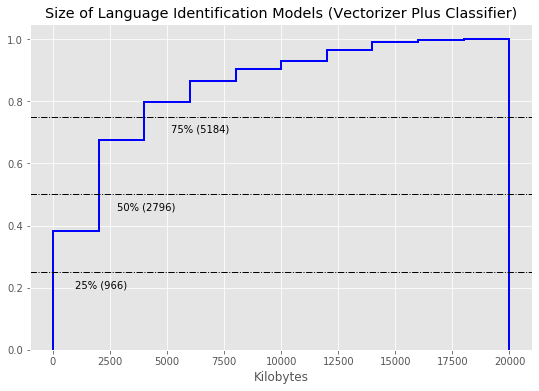

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

draw_cdf(df['size'].sort_values(),
         ax, 'Kilobytes', 'Size of Language Identification Models (Vectorizer Plus Classifier)',
         range_=(0, 20000))

plt.show()

As depicted in the above figure, 75% of language identification models (i.e., vectorizer plus classifier) weigh less than 5,184 kilobytes (approx. 5.2 megabytes), whereas the size of half of them is less than 2,796 kilobytes (approx. 2.8 megabytes).

With this in mind, let's find out which is the best language identification model by size range. First, the model with the highest accuracy and whose size is less than 967 kilobytes will be the best in the small range. Second, the model with the highest accuracy and whose size ranges from 967 to 5,184 kilobytes will be the best in the medium range. Last, the large model will be selected from those weighing more than 5,184 kilobytes.

In [33]:
size_ranges = [
    ['small', [0, 966]],
    ['medium', [967, 5184]],
    ['large', [5185, None]],
]

df['size_range'] = 'unk'

for range_desc, size_range in size_ranges:
    min_size, max_size = size_range
    
    mask = (
        ((min_size <= df['size']) & (df['size'] <= max_size)) if isinstance(max_size, int)
        else (df['size'] >= min_size)
    )
    df.loc[mask, 'size_range'] = range_desc

In [34]:
projection = [
    'size_range',
    'method',
    'n',
    'frac',
    'min_length',
    'discard_sentences',
    'accuracy',
    'vectorizer_id',
    'classifier_id',
    'size'
]

best_models = df[projection]\
              .sort_values(by=['size_range', 'accuracy', 'size'],
                           ascending=[False, False, True])\
              .drop_duplicates(subset='size_range',
                               keep='first')\
              .reset_index()\
              .drop(columns='index')

In [35]:
display(HTML(best_models.to_html()))

,size_range,method,n,frac,min_length,discard_sentences,accuracy,vectorizer_id,classifier_id,size
0,small,uniform,1000.0,NaN,10,False,0.9789,399,399,876.25
1,medium,uniform,10000.0,NaN,10,True,0.9926,32,32,1875.11
2,large,uniform,12000.0,NaN,5,True,0.9949,199,199,12772.91


As shown in the above table, the best models require a relatively small amount of data on which to train them, compared to the amount of data resulting from the stratified sampling method.

In [36]:
class LanguageIdentification(object):
    """Language identification system."""
    
    def __init__(
            self,
            vectorizer_id,
            classifier_id,
            persistence_path=MODEL_PERSISTENCE_PATH
            ):
        """Initialization, set `vectorizer_id` and `classifier_id`."""
        if (not re.match(r'[0-9]+', str(vectorizer_id))
                or int(vectorizer_id) < 1):
            raise ValueError("Set an integer value greater than zero to `vectorizer_id`.")
        
        if (not re.match(r'[0-9]+', str(classifier_id))
                or int(classifier_id) < 1):
            raise ValueError("Set an integer value greater than zero to `classifier_id`.")
        
        self.load_model(vectorizer_id, classifier_id, persistence_path)
    
    def load_model(
            self,
            vectorizer_id,
            classifier_id,
            persistence_path
            ):
        """Load the vectorizer and the classifier."""
        vectorizer_fname = os.path.join(persistence_path,
                                        'vectorizers',
                                        '{}.joblib'.format(vectorizer_id))
        self.vectorizer = joblib.load(vectorizer_fname)
        
        classifier_fname = os.path.join(persistence_path,
                                        'classifiers',
                                        '{}.joblib'.format(classifier_id))
        self.clf = joblib.load(classifier_fname)
    
    def predict(
            self,
            text,
            preprocess=True):
        """Predict the language a document, message, or sentence is written in.
        
        Parameters
        ----------
        text: str or list
        preprocess: bool
        
        Returns
        -------
        str or list
        """
        text = [text] if isinstance(text, str) else text
        
        text = (
            [preprocess_text(t) for t in text] if preprocess
            else text
        )
        
        ngram_features = self.vectorizer.transform(text)
        y = [IDX_TO_LANG[lang] for lang in self.clf.predict(ngram_features)]
        
        y = y[0] if len(y) == 1 else y
        
        return y

Finally, let's instantiate the system and test it by identifying the language in which a message is written. This system corresponds to the best model in the medium size range.

In [37]:
idendioma = LanguageIdentification(32, 32)

In [38]:
msg = 'Hoy vivimos el segundo día de agosto.'
print(idendioma.predict(msg))

spa


## 4. Experiments

First, let's list the libraries through which the ability of the approach proposed here will be compared:

1. [**langid**](https://github.com/saffsd/langid.py)
2. [**langdetect**](https://github.com/Mimino666/langdetect)
3. [**fasttext**](https://fasttext.cc/blog/2017/10/02/blog-post.html) (small pre-trained model)

Hereinafter, the proposed approach will be identified as ***idendioma***.

In [39]:
LI_SYSTEMS = [
    {
        'desc': 'idendioma (small)',
        'class': LanguageIdentification,
        'init_params': {'vectorizer_id': 399, 'classifier_id': 399},
        'batch': True
    },
    {
        'desc': 'idendioma (medium)',
        'class': LanguageIdentification,
        'init_params': {'vectorizer_id': 32, 'classifier_id': 32},
        'batch': True
    },
    {
        'desc': 'idendioma (large)',
        'class': LanguageIdentification,
        'init_params': {'vectorizer_id': 199, 'classifier_id': 199},
        'batch': True
    },
    {
        'desc': 'langid',
        'class': LanguageIdentificationHelper,
        'init_params': {'library': 'langid'},
        'batch': False
    },
    {
        'desc': 'langdetect',
        'class': LanguageIdentificationHelper,
        'init_params': {'library': 'langdetect'},
        'batch': False
    },
    {
        'desc': 'fasttext (small)',
        'class': LanguageIdentificationHelper,
        'init_params': {'library': 'fasttext'},
        'batch': True
    }
]

Second, let's list the datasets on which the performance of the proposed approach will be evaluated and compared to several third-party language identification libraries:

1. [**WiLI-2018**](https://arxiv.org/pdf/1801.07779.pdf): it is a collection of paragraphs extracted from articles written in one in 235 languages that [Wikipedia](https://wikipedia.org/) supports. Particularly, these paragraphs, whose minimum length is 140 characters, might be multilingual. For instance, the English article about [Gabriel García Márquez](https://en.wikipedia.org/wiki/Gabriel_Garc%C3%ADa_M%C3%A1rquez), a Colombian novelist awarded with the 1982 Nobel Prize in Literature, contains excerpts and special characters from the Spanish language, mostly because of the original title of his novels, such as *Cien años de soledad* (*One Hundred Years of Solitude*). Last, those paragraphs written in one out of the 14 languages the approach proposed here supports have been filtered.
2. [**LIGA**](https://www.win.tue.nl/~mpechen/projects/smm/#Datasets): it is a collection of preprocessed tweets written in one out of six languages, namely: German, English, Spanish, French, Italian, and Dutch.

In [40]:
if not os.path.isfile(DATASETS['tatoeba_test']):
    df = pd.read_csv(DATASETS['sampled'])
    
    mask = ((df['dataset'] == 'test') & (df['f1'] > 0) & (df['text'].notnull()))
    df = df.loc[mask]
    
    df = language_sampling(
        df.copy(deep=True),
        'uniform',
        n=1000,
        min_length=0,
        discard_sentences=True
        )
    
    df = df[['lang', 'text']]
    
    df.to_csv(DATASETS['tatoeba_test'], index=False)

In [41]:
LI_DATASETS = {
    'Tatoeba': DATASETS['tatoeba_test'],
    'WiLI-2018': DATASETS['wili_test'],
    'LIGA': DATASETS['liga_test'],
}

In [42]:
EXPERIMENT_HEADER = [
    'dataset',
    'system',
    'accuracy',
    'f1_score'
]

In [43]:
def evaluate_system(system, dataset_fname):
    """Evaluate the performance of a language identification system on a given dataset.
    
    Parameters
    ----------
    system: dict
    dataset_fname: str
    """
    langid = system['class'](**system['init_params'])
    
    df = pd.read_csv(dataset_fname)    
    df = df.replace(to_replace={'lang': LANG_TO_IDX})
    
    y_true = df['lang'].values.tolist()
    
    texts = df['text'].values.tolist()
    
    np.random.seed(RANDOM_SEED)
    
    default_lang = np.random.choice(np.unique(y_true), size=1)
    default_lang = default_lang[0]
    
    y_pred = langid.predict(texts) if system['batch'] else []
    
    if not system['batch']:
        for t in texts:
            try:
                y_pred.append(langid.predict(t))
            except:
                y_pred.append(default_lang)
    
    y_pred = [
        (LANG_TO_IDX[pred] if pred in LANG_TO_IDX else default_lang)
        for pred in y_pred
    ]
    
    return model_evaluation(y_true, y_pred)

In [44]:
def performance_comparison(li_systems, li_datasets, result_fname):
    """Evaluate the performance of language identification systems."""
    results = []
    
    for system, dataset_id in itertools.product(li_systems, li_datasets.keys()):
        result = {c: None for c in EXPERIMENT_HEADER}
        
        result['system'] = system['desc']
        result['dataset'] = dataset_id
        
        accuracy, f1 = evaluate_system(system, li_datasets[dataset_id])
        
        result['accuracy'] = '{:.4f}'.format(accuracy)
        result['f1_score'] = '{:.4f}'.format(f1)
        
        results.append(result)
        
        pd.DataFrame(results)[EXPERIMENT_HEADER]\
        .to_csv(result_fname, index=False, mode='w')

In [45]:
if not os.path.isfile(DATASETS['experiments']):
    performance_comparison(LI_SYSTEMS, LI_DATASETS, DATASETS['experiments'])

In [46]:
experiments = pd.read_csv(DATASETS['experiments'])

In [47]:
def language_distribution(fname):
    df = pd.read_csv(fname)
    
    lang_dist = df.groupby(['lang'])['lang']\
                .agg(['count'])\
                .reset_index()
    
    lang_dist['frac'] = lang_dist['count'] / lang_dist['count'].sum()

    lang_dist = lang_dist\
                .sort_values(by='count', ascending=False)\
                .replace(to_replace={'lang': LANGUAGES})\
                .reset_index()\
                .drop(columns='index')
    
    return lang_dist

In [48]:
def plot_performance_evaluation(df, dataset, ax):
    df = df.loc[df['dataset'] == dataset]\
         .melt(id_vars='system',
               value_vars=['accuracy', 'f1_score'],
               var_name='metric')\
         .pivot(index='system', columns='metric', values='value')

    df.plot(kind='bar', ax=ax)

    ax.grid(True)
    
    ax.set_ylim([0, 1.1])
    ax.set_xlabel(None)
    
    ax.set_title('Performance Evaluation on the {} Dataset'.format(dataset))
    
    ax.legend()

### 4.1 Tatoeba

First, let's describe this dataset, aggregating the number of samples for each language.

In [49]:
lang_dist = language_distribution(DATASETS['tatoeba_test'])
display(HTML(lang_dist.to_html()))

,lang,count,frac
0,Czech,1000,0.071429
1,Danish,1000,0.071429
2,German,1000,0.071429
3,English,1000,0.071429
4,Finnish,1000,0.071429
5,French,1000,0.071429
6,Hungarian,1000,0.071429
7,Italian,1000,0.071429
8,Dutch,1000,0.071429
9,Polish,1000,0.071429


Next, let's plot the performance of the proposed approach on this dataset and compare it to that of third-party language identification libraries.

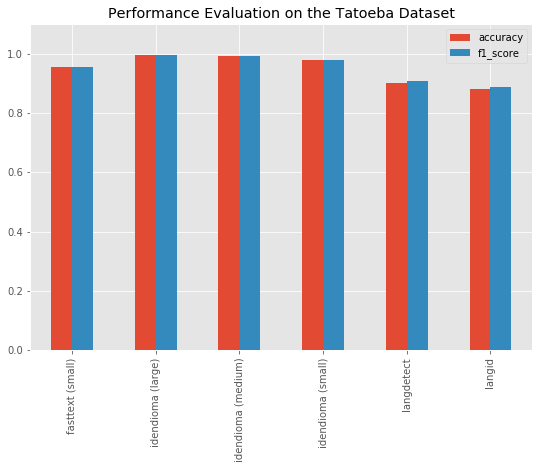

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

plot_performance_evaluation(experiments.copy(deep=True),
                            'Tatoeba',
                            ax)

plt.show()

As depicted in the above figure and expected, the performance of the proposed approach, whatever the size range, is better than that of third-party libraries, as different language identification models have been trained on only Tatoeba data.

### 4.2 WiLI-2018

Let's start by getting insights into the language distribution of this dataset.

In [51]:
lang_dist = language_distribution(DATASETS['wili_test'])
display(HTML(lang_dist.to_html()))

,lang,count,frac
0,Czech,500,0.071429
1,Danish,500,0.071429
2,German,500,0.071429
3,English,500,0.071429
4,Finnish,500,0.071429
5,French,500,0.071429
6,Hungarian,500,0.071429
7,Italian,500,0.071429
8,Dutch,500,0.071429
9,Polish,500,0.071429


Next, let's plot the performance evaluation and comparison.

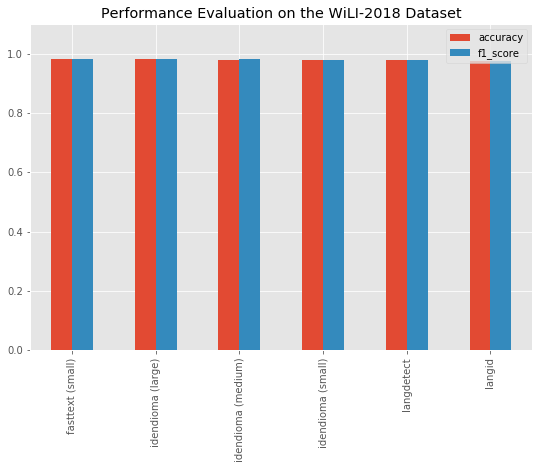

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

plot_performance_evaluation(experiments.copy(deep=True),
                            'WiLI-2018',
                            ax)

plt.show()

Overall, the performance of the **fasttext** library is the best, even though the difference with the second best-ranked model, i.e., **idendioma (large)**, is negligible.

### 4.3 LIGA

In [53]:
lang_dist = language_distribution(DATASETS['liga_test'])
display(HTML(lang_dist.to_html()))

,lang,count,frac
0,Spanish,1562,0.172292
1,French,1551,0.171079
2,Italian,1539,0.169755
3,English,1505,0.166005
4,German,1479,0.163137
5,Dutch,1430,0.157732


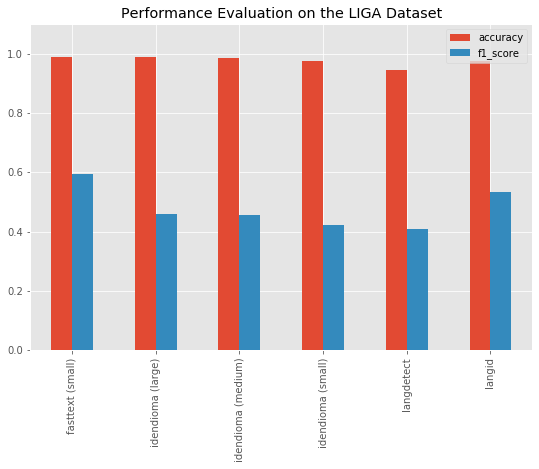

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

plot_performance_evaluation(experiments.copy(deep=True),
                            'LIGA',
                            ax)

plt.show()

In terms of accuracy, the performance of the approach proposed here is the best (i.e., 0.9902), **large** model. Instead, the **fasttext** library achieves the highest F1 score (i.e., 0.5941). Last, it is worth stating that it seems incoherent that all models perform so poorly in terms of the F1 score, considering that the language distribution of this dataset is uniform. Therefore, further investigation of this matter is required.